# Documentation #002

It's a shame that I wasn't very productive for the past week. My attempts to fit sample data into the model were in vain, hence I can't talk much about it for #002, hopefully I can make it for #003. I realised that I wasn't able to demonstrate the dynamics of the model very well last week so I'm making up for it. And then I'll briefly discuss the idea of applying Bayes' rule to models and data.

## The dynamics of the model

The DE for the model is as follows:
$$\cfrac{d\left(EX\right)}{dt} = -k_{er} \cdot \left(EX\right)$$
$$\frac{d\left(OS\right)}{dt} = k_{er} \cdot (RLR) \cdot (EX) - k_p \cdot (OS)$$
$$\frac{d(PD)}{dt} = k_p \cdot (RRF) \cdot (OS)$$

$\text{where } EX \text{ is Exposure to risk, } OS \text{ is Outstanding claims, } PD \text{ is Paid claims,}$

$k_{er} = \text{RATE at which claim events occur and subsequently reported to the insurer}$

$k_p = \text{RATE at which OS becomes paid by the insurer}$

$RLR = \text{PROPORTION of premiums that become reported claims}$

$RRF = \text{PROPORTION of outstanding claims that eventually become paid by the insurer.}$

The analytical solutions:
$$EX\left(t\right) = P \cdot e^{-k_{er}t}$$

$$OS\left(t\right) = \frac {P \cdot RLR \cdot k_{er}}{k_{er}-k_p} \cdot \left(e^{-k_pt}-e^{-k_{er}t}\right)$$

$$PD\left(t\right) = \frac {P \cdot RLR \cdot RRF}{k_{er}-k_p} \cdot \big(k_{er} \cdot \left(1-e^{-k_pt}\right)-k_p\cdot \left(1-e^{-k_{er}t}\right)\big)$$

The dynamics of the model are represented by the graphs below. I should bring together how these state variables affect the reserves in the end as well as coming up with the ultimate losses.

In [3]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np

t = np.linspace(0, 10, 1000)
P = 100.0


def update_plot(ker, kp, RLR, RRF):
    '''
    This function is linked to the sliders and
    it replots the curves when the sliders are changed.
    '''
    #########################
    #     GRAPH OUTLINE     #
    #########################
    fig, (ax1, ax2) = plt.subplots(2, figsize=(8,8))
    plt.rcParams.update({'font.size':14})
    ax1, ax2.clear()
    
    #####################
    #     VARIABLES     #
    #####################
    # STATE VARIABLES
    EX = P * np.exp(-ker * t)
    OS = P * RLR * ker / (ker - kp) * (np.exp(-kp * t) - np.exp(-ker * t))
    PD = P * RLR * RRF / (ker - kp) * (ker * (1 - np.exp(-kp * t)) - kp * (1 - np.exp(-ker * t)))
    
    INC = OS + PD
    
    # RESERVES
    ExBNR = EX * RLR * RRF
    RBNS = OS * RRF
    reserves = ExBNR + RBNS
    
    IBNR = reserves - OS
    
    
    ##########################
    #     GRAPH PLOTTING     #
    ##########################
    # ax1
    ax1.plot(t, EX, label='EX')
    ax1.plot(t, OS, label='OS')
    ax1.plot(t, PD, label='PD')
    ax1.plot(t, INC, label='INC', linestyle='--', color='k')
    ax1.legend(loc=1)
    ax1.set_xlabel('Development time $(t)$')
    ax1.set_ylabel('State-variable solutions')
    ax1.set_xlim(t[0],t[999])
    ax1.set_ylim(t[0])
    
    # ax2
    ax2.plot(t, ExBNR, label='ExBNR', color='r')
    ax2.plot(t, RBNS, label='RBNS', color='xkcd:brown')
    ax2.plot(t, reserves, label='Reserves', linestyle='-.', color='k')
    ax2.plot(t, IBNR, label='IBNR', linestyle='--', color='xkcd:grey')
    ax2.legend(loc=1)
    ax2.set_xlabel('Development time $(t)$')
    ax2.set_ylabel('Reserves')
    ax2.set_xlim(0,10)
    
    plt.tight_layout()
    plt.show()
    

ker = widgets.FloatSlider(max=10, value=1.3, description='ker:')
kp = widgets.FloatSlider(max=10, value=0.75, description='kp:')
RLR = widgets.FloatSlider(max=1, value=0.7, description='RLR:')
RRF = widgets.FloatSlider(max=10, value=0.7, description='RRF:')

widgets.interactive(update_plot, ker=ker, kp=kp, RLR=RLR, RRF=RRF)

interactive(children=(FloatSlider(value=1.3, description='ker:', max=10.0), FloatSlider(value=0.75, descriptio…

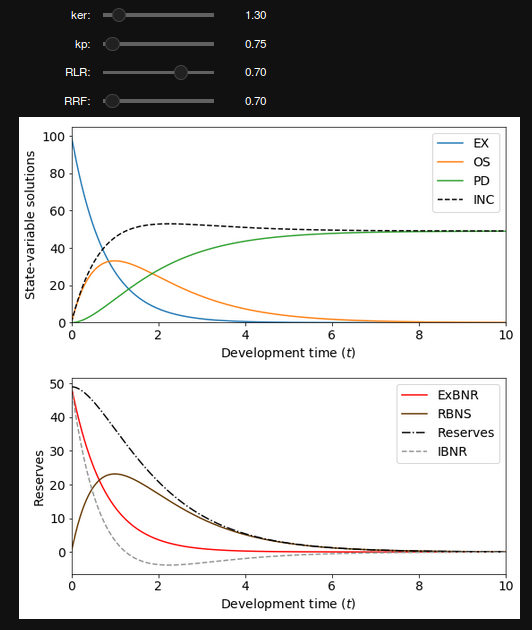

In [1]:
from IPython.display import Image
Image(filename='img/lossres_graph.png')

- There are a few assumptions made for this model:
    - It is assumed that steady-state conditions hold, i.e. policies coming on-risk are largely replaced by similar policies coming off risk, hence rate parameters are assumed to be constant over development time.
    - Earned premiums are considered as exposures and all exposures are input at time 0, which reflects those at risk at the start of the accident year and we observe their development over time.
    - These assumptions are made for simplicity for now and can be relaxed later in an advanced stage.
    
I'll first discuss about the graph on the top:
1. The exposures are at their maximum at the beginning of an accident year. As time goes by, when accidents do happen, their state will change to outstanding, else the premium will be considered 'earned' by the company. Take note that there's only a proportion of exposures that will eventually become oustanding (I mean accidents can happen to everyone but will not happen to everyone will they?), hence the need for RLR. If RLR equals 1, then accidents do happen to everyone. Exposures will then gradually decrease to zero at which point the company is no more liable to the insureds.
2. So when a proportion of exposed insured do encounter accidents, their state changes to outstanding. You can imagine this stage as waiting for the company to pay out claims, so they are setting aside money in order to fultill their liabilities. Think of it this way, the company is given an amount of money in advanced to pay for unfortunate events happening anytime in the future (policy effective period). There is a risk of accident happening everyday, so at the beginning of time the 'cummulative' risks until the end of time is higher than that during a later time. Say during the last few days of effective period, if nothing happens then the rest of the premium will be earned by the company. So the OS peak at the beginning sort of reflects this idea.
3. The amount set aside to pay for claims might be inadequate or in excess, hence the role of RRF in this matter. (I'm not sure if this value can be greater than 1.0, I should ask for professional advice, but in my humble opinion, it can.) As claims get paid, the outstanding claims will get cleared and then return to zero, while cumulatively claims are paid and so PD will gradually increase until a certain point, where no more claims from the insured of the same accident year would come in, and then from there we can tell in the end how much in total the company has paid claims for this particular cohort.
4. At any particular point of time, we can calculate the amount of incurred cases (where accidents happened and reported) by summing up OS and PD since they reflect those cases that are reported.
$$INC(t) = OS(t) + PD(t)$$



Now for the graph beneath, it's about the reserves.
Those before are those that are reported, but the insurer needs to be prepared for those they are not notified of. Hence we need to do some extrapolation using the parameters RLR and RRF.

$$ExBNR(t) = EX(t) \cdot RLR \cdot RRF$$

$$RBNS(t) = OS(t) \cdot RRF$$

$$Reserve(t) = ExBNR(t) + RBNS(t)$$

The reserves are made for known as well as unknown claims (aka IBNR: Incurred but not Reported). Since the reserve for known cases are reflected by OS(${t}$), we can extrapolate EX and OS to obtain information on the final amount to be paid and then we will know how much to allocate for unknown claims by taking out the amount for known cases from it. So we will extrapolate those in stages EX and OS to PD by multiplying RLR and RRF and obtain the reserve by summing both values. ExBNR is an abbreviation for Exposed but not Reported and RBNS and abbreviation for Reported but not Settled. Then,

$$IBNR(t) = Reserve(t) - OS(t)$$


In another way, we can extrapolate the ULTIMATE LOSSES by extrapolating the total exposures at the beginning:
$$P\cdot RLR \cdot RRF$$

and so IBNR(${t}$) can be equivalent to
$$IBNR(t) =P\cdot RLR \cdot RRF - INC(t)$$


Again, there's a better way to do the plotting using bokeh if it's meant to be interactive (as in you can move the sliders and see the effects of changes in parameters to the model, but in github it's a dead HTML). I've had some troubles dealing with zero-division errors and a few other assumptions (which I've yet to find out) while exploring holoviews. Anyway I feel that I should at least do justice to the reasonable amount of time I've spent coming up with these few lines of codes, so I'll just use them here while planning to dump them in near future. (Dilemmas of a novice in programming)

## The Bayes Rule

$$\Pr\left( y \vert x \right) = \frac{p(x,y)}{p(x)}$$
${\\}$
$$p(x,y) = \Pr\left( y \vert x \right) \cdot p(x)$$
${\\}$
Similarly,
${\\}$
$$\Pr\left( x \vert y \right) = \frac{p(x,y)}{p(y)}$$
${\\}$
$$p(x,y) = \Pr\left( x \vert y \right) \cdot p(y)$$

Hence,

$$\Pr\left( y \vert x \right) \cdot p(x) = \Pr\bigl( x \bigm\vert y \bigr) \cdot p(y)$$

$$\Pr\left( y \vert x \right)= \frac{\Pr\bigl( x \bigm\vert y \bigr) \cdot p(y)}{p(x)}$$

$$\Pr\bigl( y \bigm\vert x \bigr)= \frac{\Pr\bigl( x \bigm\vert y \bigr) \cdot p(y)}{\sum_{y}\Pr\bigl( x \bigm\vert y \bigr) \cdot p(y)}$$

Substituting ${\theta}$ as model parameter to ${y}$ and ${D}$ as data to ${x}$, we can see how we switch from probability of the data according to the model, to the probability of the model given the data.

$$\underbrace{\Pr\bigl( \theta \bigm\vert D \bigr)}_\text{posterior}= \frac{\overbrace{\Pr\bigl( D \bigm\vert \theta \bigr)}^\text{likelihood} \cdot \overbrace{p(\theta)}^\text{prior}}{\underbrace{\sum_{\theta}\Pr\bigl( D \bigm\vert \theta \bigr) \cdot p(\theta)}_\text{evidence}}$$

For continuous variables, the Bayes' rule becomes 
$$\Pr\bigl( \theta \bigm\vert D \bigr)= \frac{\Pr\bigl( D \bigm\vert \theta \bigr) \cdot p(\theta)}{\int_{\theta}\Pr\bigl( D \bigm\vert \theta \bigr) \cdot p(\theta)}$$





 - "posterior" is the strength of our belief in ${\theta}$ when the data ${D}$ have been taken into account.
 - "prior" is the strength of our belief in ${\theta}$ without the data ${D}$. 
 - "likelihood" is the probability that the data ${D}$ could be generated by the model with parameter values ${\theta}$.
 - "evidence" is the probability of the data ${D}$ according to the model, determined by summing across all possible parameter values ${\theta}$ weighted by the strength of belief in those parameter values. As we can also see the "evidence" is restricting our attention to ${D}$ by summing across ${\theta}$. Dividing the values by their sums is also called "normalizing" the values.

The posterior above is only in the context of a particular model ${M}$, if we were to compare across different models, we can state our posterior as follows:

$$\underbrace{\Pr\bigl( \theta \bigm\vert D,M \bigr)}_\text{posterior}= \frac{\overbrace{\Pr\bigl( D \bigm\vert \theta,M \bigr)}^\text{likelihood} \cdot \overbrace{p(\theta\vert M)}^\text{prior}}{\underbrace{\sum_{\theta}\Pr\bigl( D \bigm\vert \theta ,M \bigr) \cdot p(\theta \vert M)}_\text{evidence}}$$

$${\Pr\bigl( \theta \bigm\vert D,M \bigr)}= \frac{{\Pr\bigl( D \bigm\vert \theta,M \bigr)} \cdot {p(\theta\vert M)}}{p(D \vert M)}$$

${p(D \vert M)}$ in this context means the evidence for model ${M}$. When considering for example models ${M_A}$ and ${M_B}$, 

$$\Pr\bigl( M_A \bigm\vert D \bigr) = \frac{p(D \vert M_A) \cdot p(M_A)}{p(D)}$$

${p(D \vert M_A)}$ refers to the likelihood of the model ${M_A}$ for the data ${D}$ and ${p(D)}$ refers to the evidence for the entire set of models.

When we have observed some data, we can use Bayes' rule to determine our beliefs across competing parameter values in a model as well as to determine our beliefs across competing models. The posteriors are actually measures of our belief.




## Next up

- So far from above those are only simulations made from analytical solutions. 
- I will have to make it work with data (both frequentist modelling as well as bayesian modelling). Since I'll be fitting in data not for just one accident year but 10 accident years in the sample, we will probably be dealing with matrices. (Different earned premiums at the beginning, different parameters for each accident year)
- Once fitting with data is possible only I can explore MCMC methods on bayesian modelling.
- I will also justify the need for doing frequentist modelling as well. (It's now still a hypothesis)